# GTSRB Dataset

**Problem:** Implement a neural network model capable of identifying a german road sign as accuratelly as possible.

In this notebook we will start with a simple model and train it without any data augmentation. This allows us to get a base value for our accuracy, so that we can better grasp the improvements or regressions obtained from our methods.

In [53]:
# Imports
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import (
    Conv2D, 
    Conv2DTranspose, 
    BatchNormalization, 
    LeakyReLU, 
    Flatten, 
    Dense, 
    Reshape, 
    Input,
    Activation
)
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.data import AUTOTUNE

import matplotlib.pyplot as plt

import numpy as np
from PIL import Image
import glob

import os

## Constants

In [73]:
HEIGHT = 39
WIDTH = 39
NUM_CHANNELS = 3 # Pictures are in RGB
BATCH_SIZE = 32
DATASET_PATH = '../dataset'
NUM_CLASSES = 43
CLASS_NAMES = os.listdir(f'{DATASET_PATH}/test_images')
EPOCHS = 20

TRAIN_ONLINE = True
CONVERT_DATASET = False

## Auxiliary functions
These help with visualizing data and predictions

In [75]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(CLASS_NAMES[predicted_label],
                                100*np.max(predictions_array),
                                CLASS_NAMES[true_label]),
                                color=color)


def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
def plot_predictions(predictions, ground_truth, num_rows= 5, num_cols=3 ):

    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], ground_truth, x_test)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth)
    plt.tight_layout()
    plt.show()

## Convert dataset to PNG

For some reason tensorflow does not support PPM

In [55]:
if CONVERT_DATASET:
    for path in glob.iglob(f'{DATASET_PATH}/**/*.ppm', recursive=True):
        img = Image.open(path, mode='r')
        new_path = path.replace('.ppm', '.png')
        img.save(new_path)

## Load and prepare datasets

In [69]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f'{DATASET_PATH}/train_images/GTSRB/Final_Training/Images',
    image_size=(WIDTH,HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=True,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f'{DATASET_PATH}/test_images',
    image_size=(WIDTH,HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Normalize image pixels
normalize = tf.keras.layers.Rescaling(1.0/255.0)
train_ds = train_ds.map(lambda x,y: (normalize(x),y))
test_ds = test_ds.map(lambda x,y: (normalize(x),y))

train_ds.cache()
train_ds.prefetch(buffer_size=10000)

Found 39209 files belonging to 43 classes.
Found 12630 files belonging to 43 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 39, 39, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 43), dtype=tf.float32, name=None))>

## Get dataset info

In [65]:
image_batch, label_batch = next(iter(train_ds))
num_batches = train_ds.cardinality().numpy()

print(f'Image shape: {image_batch[0].numpy().shape}')
print(f'Label: {label_batch[0].numpy()}')
print(f'Number of batches: {num_batches}')

2023-06-02 23:01:11.387801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [39209]
	 [[{{node Placeholder/_4}}]]
2023-06-02 23:01:11.390664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [39209]
	 [[{{node Placeholder/_0}}]]


Image shape: (39, 39, 3)
Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Number of batches: 1226


## Model creation

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 39, 39, 64)        1792      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 39, 39, 64)        0         
                                                                 
 batch_normalization_12 (Bat  (None, 39, 39, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 39, 39, 64)        36928     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 39, 39, 64)        0         
                                                                 
 batch_normalization_13 (Bat  (None, 39, 39, 64)       256       
 chNormalization)                                     

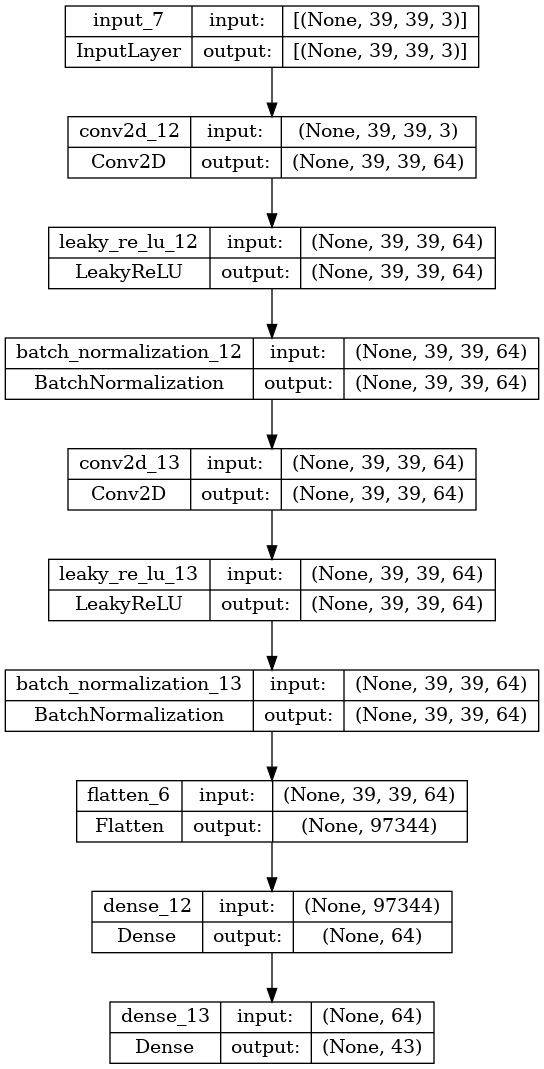

In [66]:
model = Sequential()

model.add(Input(shape=(WIDTH,HEIGHT,NUM_CHANNELS)))

model.add(Conv2D(64, (3,3), padding='same'))
model.add(LeakyReLU(alpha=0.02))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), padding='same'))
model.add(LeakyReLU(alpha=0.02))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64))
model.add(Dense(NUM_CLASSES, activation='softmax'))

opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

## Train the model and view history

In [67]:
hist = model.fit(train_ds, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/20
1226/1226 [==============================] - 19s 13ms/step - loss: 3.8880 - accuracy: 0.8533
Epoch 2/20
1226/1226 [==============================] - 14s 12ms/step - loss: 0.5401 - accuracy: 0.9600
Epoch 3/20
1226/1226 [==============================] - 14s 12ms/step - loss: 0.3600 - accuracy: 0.9712
Epoch 4/20
1226/1226 [==============================] - 13s 11ms/step - loss: 0.3014 - accuracy: 0.9756
Epoch 5/20
1226/1226 [==============================] - 13s 11ms/step - loss: 0.2402 - accuracy: 0.9802
Epoch 6/20
1226/1226 [==============================] - 14s 11ms/step - loss: 0.1903 - accuracy: 0.9845
Epoch 7/20
1226/1226 [==============================] - 13s 11ms/step - loss: 0.1613 - accuracy: 0.9852
Epoch 8/20
1226/1226 [==============================] - 14s 11ms/step - loss: 0.1504 - accuracy: 0.9863
Epoch 9/20
1226/1226 [==============================] - 13s 11ms/step - loss: 0.0872 - accuracy: 0.9907
Epoch 10/20
1226/1226 [==============================] - 14s 11m

In [76]:
results = model.evaluate(test_ds, verbose=2)

print(results)

395/395 - 3s - loss: 1.2970 - accuracy: 0.9313 - 3s/epoch - 7ms/step
[1.2969765663146973, 0.9312747716903687]
